In [115]:
import pandas as pd
import time
import sys
import os
import re


nombre_target = "../csv/eduroam/Eduroam_08112022.csv"

datos_edu = pd.read_csv(nombre_target, sep=',',on_bad_lines="skip")

datos_pc = pd.read_csv("../csv/off/csv_offline_filter/pcount_filter_2022-11-08.csv", sep=';',on_bad_lines="skip")


In [116]:
def arreglarMAC(oidObject):
    oidObject = oidObject[-14:-2]
    return oidObject[0:2] + ':' + oidObject[2:4] + ':' + oidObject[4:6] + ':' + oidObject[6:8] + ':' + oidObject[8:10] + ':' + oidObject[10:12] 


def arreglo_df_Wifi_A(dataframe_Wifi_A):

    # Creación de la lista de IP de APs que nos interesan
    lista_nombre_APs = ['ANT-PB-N-O-Biblio', 'ANT-PB-N-C-Biblio', 'ANT-PB-N-E-Biblio', 'ANT-PB-E-NN-Biblio', 'ANT-PB-E-N-Biblio', 'ANT-PB-E-S-Biblio', 'ANT-PB-E-SS-Biblio']
    lista_IPs_APs = ['192.168.89.189', '192.168.89.187', '192.168.89.111', '192.168.89.184', '192.168.89.181', '192.168.89.182', '192.168.89.249']
    lista_IPs_APs = dict(zip(lista_nombre_APs, lista_IPs_APs))

    lista_completa_APs = lista_IPs_APs
    lista_completa_APs = pd.Series(lista_completa_APs)

    dataframe_Wifi_A = dataframe_Wifi_A.copy()
    dataframe_Wifi_A.columns = ['Nº Secuencia', 'Fecha_Hora', 'MAC','MACWLAN', 'IP', 'IPAP', 'Nombre', 'sistema operativo', 'relacion SN', 'TXDataFr', 'TXDataBy', 'TXRetries', 'TXRate', 'RXDataFr', 'RXDataBy', 'RXRetries', 'RXRate']
    dataframe_Wifi_A.drop_duplicates(inplace=True)
    dataframe_Wifi_A = dataframe_Wifi_A[(dataframe_Wifi_A['MAC'] != '0') & (dataframe_Wifi_A['MAC'].notna()) & (dataframe_Wifi_A['MACWLAN'].notna()) & (dataframe_Wifi_A['IP'].notna()) & (dataframe_Wifi_A['IPAP'].notna())]

    # Código propio para arreglar las columnas de MACs e IPs respecto a la nomenclatura SNMP.
    dataframe_Wifi_A['MAC'] = [arreglarMAC(oid) for oid in dataframe_Wifi_A['MAC']]
    dataframe_Wifi_A['MACWLAN'] = [arreglarMAC(oid) for oid in dataframe_Wifi_A['MACWLAN']]

    # Código TFM, mediante expresiones regulares, para arreglar MACs e IPs respecto nomenclatura SNMP
    dataframe_Wifi_A['IP'] = dataframe_Wifi_A['IP'].str.extract(r" ([\d\.]+)']$")
    dataframe_Wifi_A['IPAP'] = dataframe_Wifi_A['IPAP'].str.extract(r" ([\d\.]+)']$")

    # Algunas MACs están corruptas, por lo que aplicamos esta expresión regular para filtrarlas
    # Fuente: https://stackoverflow.com/questions/7629643/how-do-i-validate-the-format-of-a-mac-address
    dataframe_Wifi_A['MAC'] = dataframe_Wifi_A['MAC'].apply(lambda x: x if re.match("[0-9a-f]{2}([-:]?)[0-9a-f]{2}(\\1[0-9a-f]{2}){4}$", x.lower()) else 0)
    dataframe_Wifi_A = dataframe_Wifi_A[dataframe_Wifi_A['MAC'] != 0]

    dataframe_Wifi_A = dataframe_Wifi_A[dataframe_Wifi_A['IPAP'].isin(lista_completa_APs)]
    dataframe_Wifi_A = dataframe_Wifi_A[~dataframe_Wifi_A["IP"].str.contains("192.168.102.")]

    return  dataframe_Wifi_A

In [117]:
datos_edu = arreglo_df_Wifi_A(datos_edu)
datos_edu.to_csv("../csv/eduroam/2022-11-08_eduroam.csv",index=False)

In [118]:
ts = datos_edu["Fecha_Hora"].drop_duplicates()
ts

10        2022-11-08 08:00:02
109       2022-11-08 08:03:01
216       2022-11-08 08:06:01
330       2022-11-08 08:12:01
469       2022-11-08 08:15:01
                 ...         
175534    2022-11-08 22:42:02
175607    2022-11-08 22:45:02
175681    2022-11-08 22:48:02
175753    2022-11-08 22:51:02
175825    2022-11-08 22:57:02
Name: Fecha_Hora, Length: 264, dtype: object

In [119]:
datos_edu[datos_edu["Fecha_Hora"].str.contains("2022-11-08 08:00")].drop_duplicates(["MAC"])

,Nº Secuencia,Fecha_Hora,MAC,MACWLAN,IP,IPAP,Nombre,sistema operativo,relacion SN,TXDataFr,TXDataBy,TXRetries,TXRate,RXDataFr,RXDataBy,RXRetries,RXRate
10,11,2022-11-08 08:00:02,00:1e:c2:b9:0b:a9,cc:88:c7:09:c5:91,192.168.249.9,192.168.89.182,ja.delolmofernandez@um.es,macOS,48.0,88.0,16099.0,4.0,270.0,160.0,24626.0,0.0,270.0
18,19,2022-11-08 08:00:02,10:32:7e:d3:07:ac,cc:88:c7:08:64:c1,192.168.245.132,192.168.89.181,22952066K@upct.es,Android,35.0,271.0,121335.0,4.0,65.0,565.0,79803.0,20.0,1.0
21,22,2022-11-08 08:00:02,18:f0:e4:34:16:48,cc:88:c7:08:64:c1,192.168.245.144,192.168.89.181,22996267@upct.es,Android,47.0,99.0,30555.0,0.0,72.0,154.0,17535.0,0.0,1.0
31,32,2022-11-08 08:00:02,42:b1:f8:c8:c9:d5,cc:88:c7:09:c5:81,192.168.245.188,192.168.89.182,22997957G@upct.es,Linux,28.0,329.0,111307.0,39.0,72.0,556.0,86678.0,61.0,72.0
32,33,2022-11-08 08:00:02,4a:50:6a:eb:65:77,cc:88:c7:09:c5:91,192.168.245.165,192.168.89.182,29154796L@upct.es,Linux,27.0,56241.0,71473529.0,91.0,300.0,11749.0,1590088.0,303.0,150.0
60,61,2022-11-08 08:00:02,a4:55:90:7c:29:95,cc:88:c7:09:c5:91,192.168.244.63,192.168.89.182,27450941@upct.es,Linux,9.0,1180.0,373592.0,44.0,81.0,2335.0,463284.0,77.0,6.0
65,66,2022-11-08 08:00:02,a8:76:50:ab:aa:20,cc:88:c7:09:c5:91,192.168.245.138,192.168.89.182,anonymous@upct.es,Linux,20.0,706.0,511394.0,5.0,135.0,908.0,141176.0,12.0,135.0
67,68,2022-11-08 08:00:02,b6:72:84:9f:be:62,cc:88:c7:07:e3:c1,192.168.244.227,192.168.89.249,22952309B@upct.es,NOFP,28.0,801.0,766396.0,51.0,144.0,1447.0,161895.0,184.0,78.0
77,78,2022-11-08 08:00:02,d2:8d:f5:9e:bc:ea,cc:88:c7:09:c5:81,192.168.245.117,192.168.89.182,27437095@upct.es,Linux,35.0,380.0,99026.0,4.0,65.0,625.0,80036.0,50.0,65.0
92,93,2022-11-08 08:00:02,f2:e6:6a:0c:05:27,cc:88:c7:08:64:d1,192.168.244.176,192.168.89.181,29154796,NOFP,40.0,7940.0,4921700.0,101.0,270.0,13839.0,1075409.0,114.0,300.0


In [120]:
def get_datagraph(df):
    times=[]
    cuentas=[]
    for i in ts:
        pcnt = len(df[df['Fecha_Hora']==i]['MAC'].drop_duplicates())
        times.append(i)
        cuentas.append(pcnt)

    r = pd.DataFrame(columns=['Timestamp','Ocupacion'])
    r['Timestamp'] = times
    r['Ocupacion'] = cuentas
    r['Timestamp'] = pd.to_datetime(r['Timestamp'], dayfirst=True)
    return r

In [121]:
datos_edu_A = datos_edu[datos_edu['IPAP'].isin(["192.168.89.182","192.168.89.249"])]
datos_edu_B = datos_edu[datos_edu['IPAP'].isin(["192.168.89.184","192.168.89.181"])]
datos_edu_CDE = datos_edu[datos_edu['IPAP'].isin(["192.168.89.111","192.168.89.187","192.168.89.189"])]


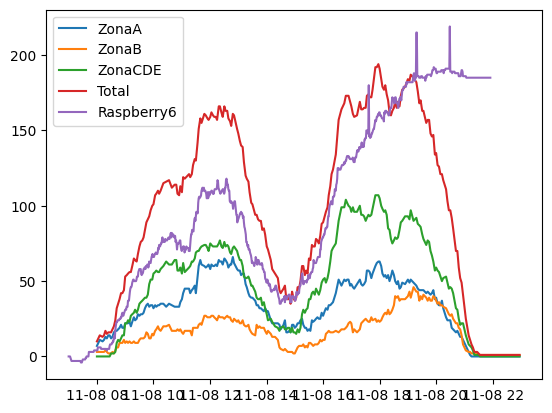

In [122]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

datos_pc['Timestamp'] = datos_pc['Fecha'] + " " + datos_pc['Hora']
datos_pc['Timestamp'] = pd.to_datetime(datos_pc['Timestamp'], dayfirst=True)
datos_edu['Fecha_Hora'] = pd.to_datetime(datos_edu['Fecha_Hora'], dayfirst=True)

datos_edu_A = datos_edu[datos_edu['IPAP'].isin(["192.168.89.182","192.168.89.249"])]
datos_edu_B = datos_edu[datos_edu['IPAP'].isin(["192.168.89.184","192.168.89.181"])]
datos_edu_CDE = datos_edu[datos_edu['IPAP'].isin(["192.168.89.111","192.168.89.187","192.168.89.189"])]


datos_edu_A = get_datagraph(datos_edu_A)
ax.plot(datos_edu_A['Timestamp'],datos_edu_A['Ocupacion'])

datos_edu_B = get_datagraph(datos_edu_B)
ax.plot(datos_edu_B['Timestamp'],datos_edu_B['Ocupacion'])

datos_edu_CDE = get_datagraph(datos_edu_CDE)
ax.plot(datos_edu_CDE['Timestamp'],datos_edu_CDE['Ocupacion'])

datos_edu = get_datagraph(datos_edu)
ax.plot(datos_edu['Timestamp'],datos_edu['Ocupacion'])


ax.plot(datos_pc['Timestamp'],datos_pc['Ocupacion'])


ax.legend(['ZonaA','ZonaB','ZonaCDE','Total','Raspberry6'])

In [123]:
datos_edu_A['Timestamp']

0     2022-11-08 08:00:02
1     2022-11-08 08:03:01
2     2022-11-08 08:06:01
3     2022-11-08 08:12:01
4     2022-11-08 08:15:01
              ...        
259   2022-11-08 22:42:02
260   2022-11-08 22:45:02
261   2022-11-08 22:48:02
262   2022-11-08 22:51:02
263   2022-11-08 22:57:02
Name: Timestamp, Length: 264, dtype: datetime64[ns]